Reading "wind-speed" files

Pour ce code :
- read raw
- resample 10min
- process 10min
- plot 10min data
- save 10min database ***

# Importation des bibliothèques

In [1]:
import sys

%matplotlib inline

!{sys.executable} -m pip install --upgrade pip netCDF4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import netCDF4
from scipy import stats
from scipy import optimize
from scipy.stats import linregress

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 100.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


# Lecture des données

In [2]:
#reading data
import os
path = 'wind-speed/'

date_list = sorted(os.listdir(path))
list_file_name = list()
for i in range (0,len(date_list)):
    list_file_name.append(date_list[i])
print(list_file_name)

['Wind_data_2024-10-11.csv', 'Wind_data_2024-10-12.csv', 'Wind_data_2024-10-13.csv', 'Wind_data_2024-10-14.csv', 'Wind_data_2024-10-15.csv', 'Wind_data_2024-10-16.csv', 'Wind_data_2024-10-17.csv', 'Wind_data_2024-10-18.csv', 'Wind_data_2024-10-19.csv', 'Wind_data_2024-10-20.csv', 'Wind_data_2024-10-21.csv', 'Wind_data_2024-10-22.csv', 'Wind_data_2024-10-23.csv']


In [3]:
#reading CSV file
list_data_all = [pd.DataFrame() for i in range(0, len(date_list))]
for i in range (0,len(date_list)):
    list_data_all[i] = pd.read_csv(path+list_file_name[i],parse_dates = True,sep=',',index_col=0)

# Filtration des données invalides

In [4]:
l_lignes = list()
l_colonnes = list()

for i in range (0,len(list_data_all)):
    l_lignes.append(list(list_data_all[i].index))
    l_colonnes.append(list(list_data_all[i].columns))
    list_data_all[i] = list_data_all[i].to_numpy()

In [5]:
for i in range (0,len(list_data_all)):
    for x in list_data_all[i]:
        for j in range(3, len(x), 5):
            if x[j] == 0:
                x[j-1] = np.nan
                x[j-2] = np.nan
                x[j-3] = np.nan
    list_data_all[i] = pd.DataFrame(list_data_all[i], columns=l_colonnes[i], index=l_lignes[i])

# Filtration temporelle à 10 minutes

In [6]:
# Fixing the datetime conversion error based on the error message suggestion
# Using format='ISO8601' to parse the datetime strings
list_data_all_10min = [pd.DataFrame() for i in range(0, len(date_list))]
list_data_all_std = [pd.DataFrame() for i in range(0, len(date_list))]
list_data_all_count = [pd.DataFrame() for i in range(0, len(date_list))]

for i in range (0,len(list_data_all)):
    list_data_all[i].index = pd.to_datetime(list_data_all[i].index, format='ISO8601')
    list_data_all_10min[i] = list_data_all[i].resample('10T').mean()
    list_data_all_std[i] = list_data_all[i].resample('10T').std()
    list_data_all_count[i] = list_data_all[i].resample('10T').count()

print(len(list_data_all_10min[12]))

47


# Étude de la loi de puissance

In [7]:
l_lignes_10min = list()
for i in range (0,len(list_data_all_10min)):
    l_lignes_10min.append(list(list_data_all_10min[i].index))

In [8]:
#étude avec loi en puissance
#écriture du tableau de tous les alpha pour chaque 10min

alpha = []
alpha_frame = []
for i in range (0,len(list_data_all_10min)):
    if type (list_data_all_10min[i]) == pd.core.frame.DataFrame :
        list_data_all_10min[i] = list_data_all_10min[i].to_numpy()
    alpha.append(np.empty((len(list_data_all_10min[i]),45)))

colonnes_alpha = list()
abscisses = list()
for k in range (1,46):
    colonnes_alpha.append('alpha_'+str((k+5)*10))
    abscisses.append((k+5)*10)
abscisses = np.array(abscisses)

for i in range (0,len(list_data_all_10min)):
    for row_idx, x in enumerate(list_data_all_10min[i]) :
        for j in range (5,226,5) :
            alpha[i][row_idx,int(j/5)-1] = np.log(x[j]/x[0])/np.log(x[j+4]/50)

    alpha_frame.append(pd.DataFrame(alpha[i], columns=colonnes_alpha, index=l_lignes_10min[i]))
    list_data_all_10min[i] = pd.DataFrame(list_data_all_10min[i], columns=l_colonnes[i], index=l_lignes_10min[i])



In [9]:
#interpolation pour garder un alpha par tranche de 10 minutes
alpha_moy = np.zeros((len(alpha_frame[0]),len(alpha_frame)))

for j in range (0, len(alpha_frame)) : 
    for i in range (0,len(alpha_frame[j])) : 
        alpha_mask = np.ma.masked_array(alpha[j], mask=np.isnan(alpha[j]))
        alpha_graph = alpha_mask[i]
        abscisses_graph = np.array(abscisses)[~alpha_graph.mask]
        alpha_graph_comp = alpha_graph[~alpha_graph.mask]

        if len(alpha_graph_comp) < 3 : 
            alpha_moy[i][j] = np.nan
    
        else :
            slope, intercept, r_value, p_value, std_err = linregress(abscisses_graph, alpha_graph_comp)
            alpha_moy[i][j] = slope
        #plt.scatter(abscisses_graph,alpha_graph_comp, color='blue', label='Données')
        #plt.plot(abscisses_graph, slope * abscisses_graph + intercept, color='red', label='Régression linéaire')
        #plt.xlabel('z (en m)')
        #plt.ylabel('alpha')
        #plt.legend()
        #plt.show()

#ajouter la première colonne avec les dates
#cacher les dates correspondant aux nan

print((alpha_moy[:,12]))

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan  0.00351904  0.02256827  0.02574524  0.0098611
  0.00550054  0.01326654  0.0386474   0.01854822  0.03218812  0.02349681
  0.01407844  0.01771278  0.00788883 -0.01740336         nan  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.       

<AxesSubplot: >

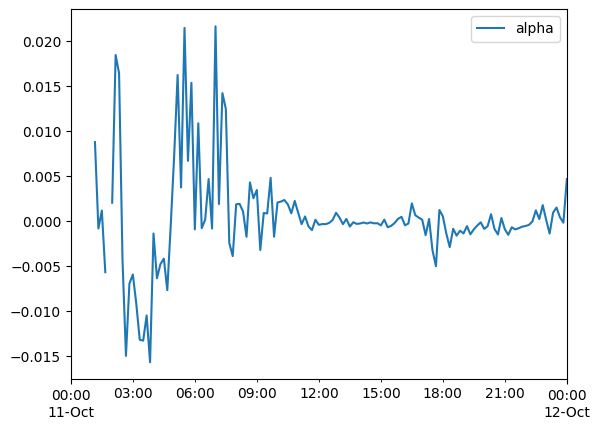

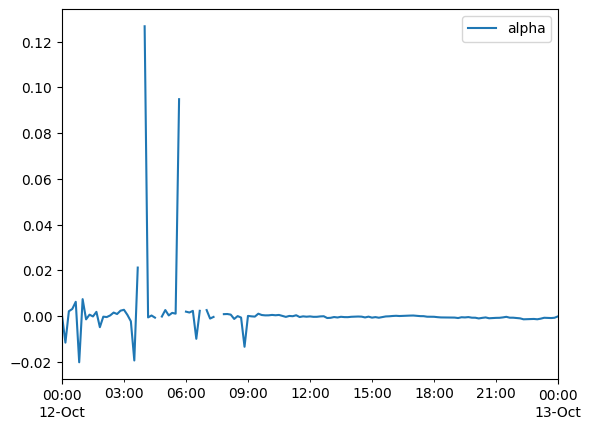

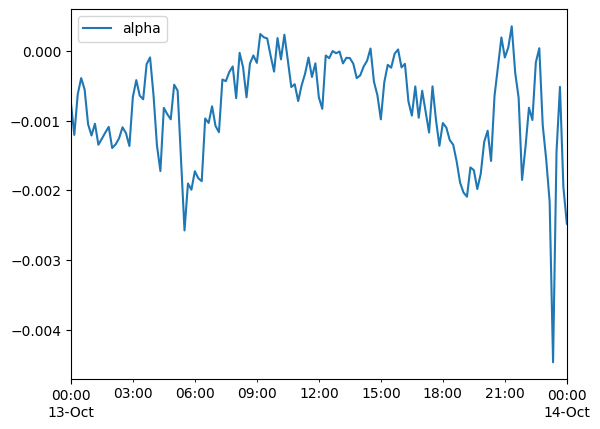

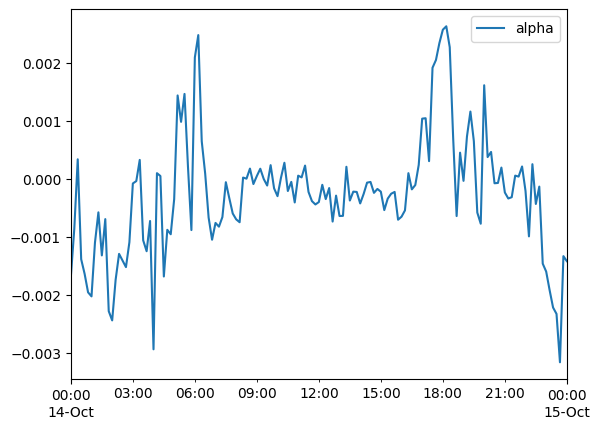

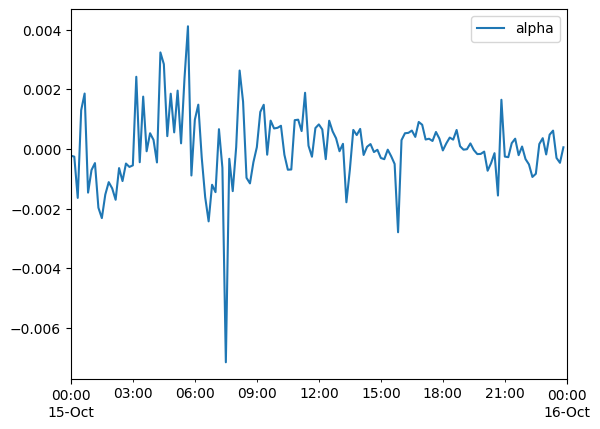

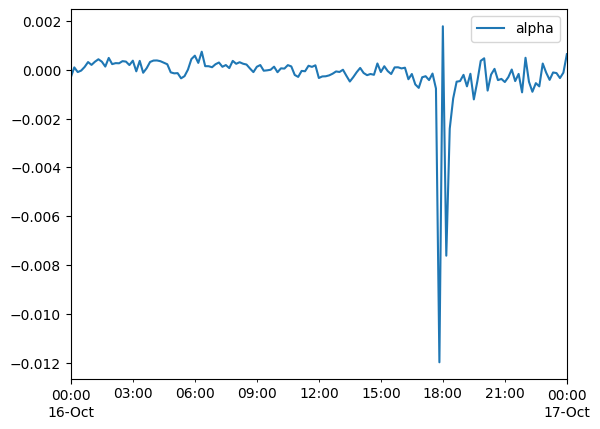

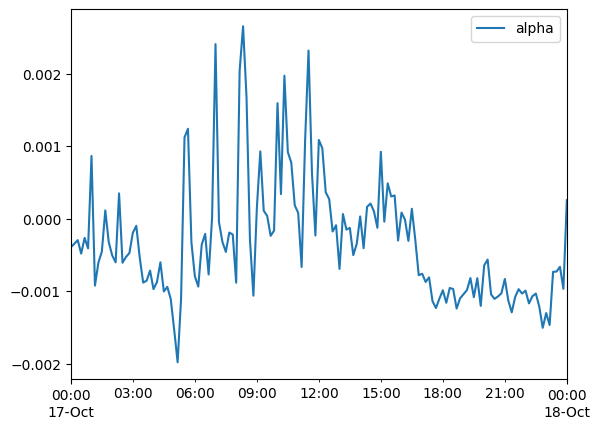

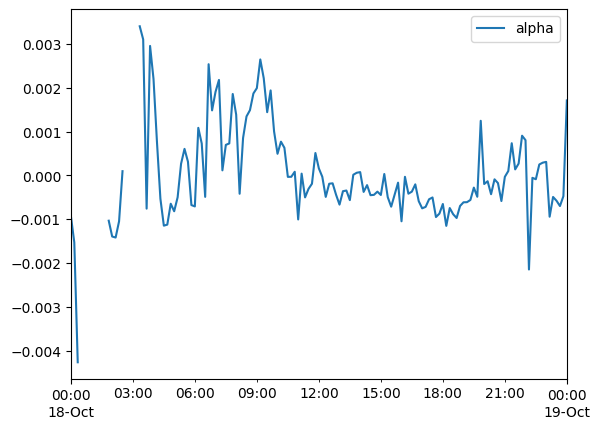

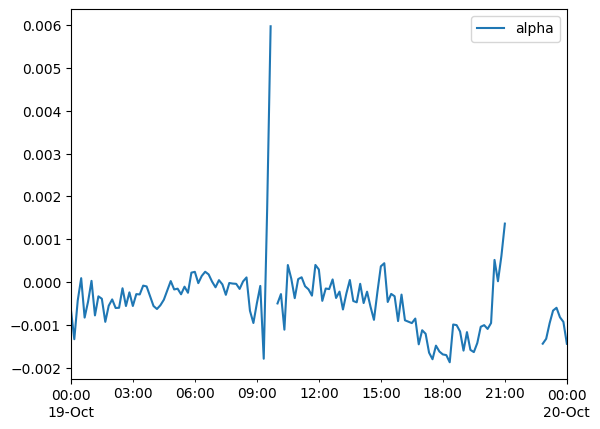

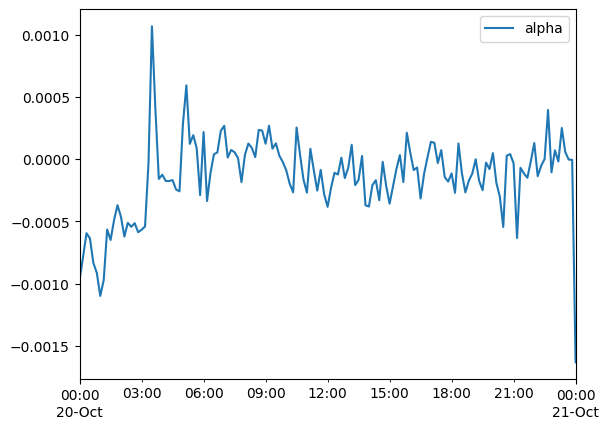

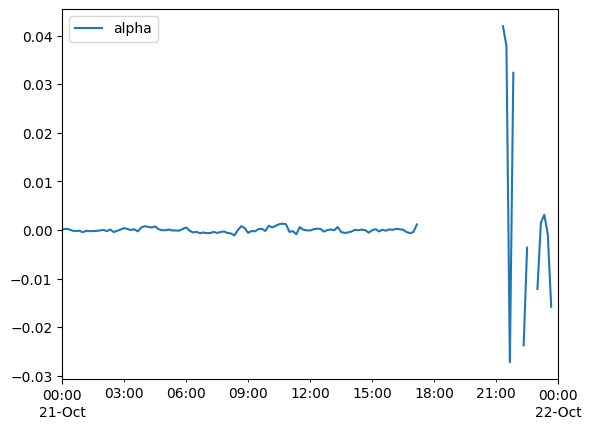

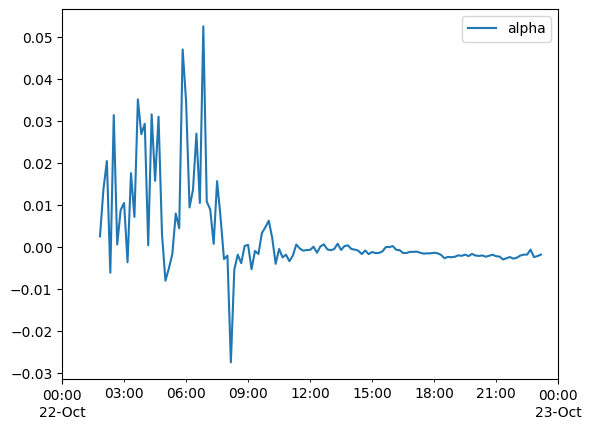

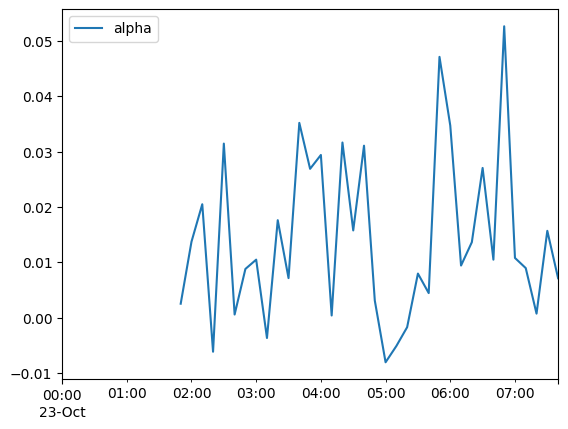

In [10]:
#ajout du tableau général et tracé des alpha en fonction du temps
for i in range (0,len(list_data_all_10min)-1):
    list_data_all_10min[i]['alpha'] = alpha_moy[:,i]
    list_data_all_10min[i].plot(y='alpha')

list_data_all_10min[12]['alpha'] = alpha_moy[:47,i]
list_data_all_10min[12].plot(y='alpha')
#tracé des alpha en fonction du temps

[0.0003745941022315425, 0.0011624625093473178, -0.0007924399132365291, -0.0002639698877666952, 3.6737462373852406e-05, -0.00018980974708723136, -0.0003199859219796666, 3.326087896694178e-05, -0.0004356321947665535, -0.00013901353850864887, 0.0004887934767622373, 0.002830709546166878, 0.014225727992427217]
0.0013085719049946664


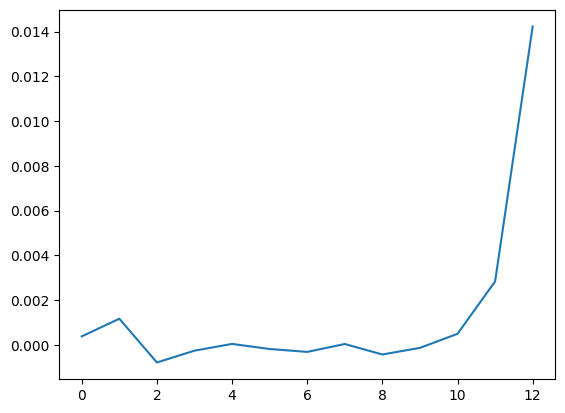

In [11]:
alpha_jour = []
for i in range (0,len(list_data_all_10min)):
    alpha_jour.append(np.mean(list_data_all_10min[i]['alpha']))
print(alpha_jour)
plt.plot(alpha_jour)
test = np.mean(alpha_jour)
print (test)

# Étude de la loi logarithmique

In [12]:
abscisses = pd.DataFrame(abscisses)

log = []
log_frame = []

for i in range (0,len(list_data_all_10min)):
    if type (list_data_all_10min[i]) == pd.core.frame.DataFrame :
        list_data_all_10min[i] = list_data_all_10min[i].to_numpy()
    log.append(np.empty((len(list_data_all_10min[i]),45)))

colonnes_log = list()
for k in range (1,46):
    colonnes_log.append('log_'+str((k+5)*10))

for i in range (0,len(list_data_all_10min)):
    for row_idx, x in enumerate(list_data_all_10min[i]) :
        for j in range (5,226,5) :
            log[i][row_idx,int(j/5)-1] = np.log(x[j]/x[0])/np.log(x[j+4]/50)

    alpha_frame.append(pd.DataFrame(alpha[i], columns=colonnes_alpha, index=l_lignes_10min[i]))
    list_data_all_10min[i] = pd.DataFrame(list_data_all_10min[i], columns=l_colonnes[i], index=l_lignes_10min[i])


ValueError: Shape of passed values is (145, 231), indices imply (145, 230)

In [13]:
# 1. Filtrer les colonnes qui commencent par 'HWS_' et qui contiennent des valeurs numériques (int ou float)
valid_columns = []
column_numbers = []

# Parcourir toutes les colonnes du DataFrame
for col in data_all_10min.columns:
    # Vérifier que le nom de la colonne commence par 'HWS_'
    if isinstance(col, str) and col.startswith('HWS_'):
        try:
            # Extraire le numéro de la colonne (par exemple 'HWS_50' devient 50)
            num = int(col.split('_')[1])
            # Vérifier que la colonne contient des valeurs numériques (float ou int)
            if np.issubdtype(data_all_10min[col].dtype, np.number):
                valid_columns.append(col)
                column_numbers.append(num)
        except (ValueError, IndexError):
            # Si l'extraction du numéro échoue ou si la colonne ne suit pas le format attendu, l'ignorer
            continue

# 2. Si des colonnes valides sont trouvées, calculer ln(x) pour les numéros extraits
if column_numbers:
    ln_column_numbers = np.log(column_numbers)
else:
    raise ValueError("Aucune colonne valide 'HWS_' avec des numéros numériques trouvée.")

# 3. Tracer les lignes de HWS_x en fonction de ln(x)
plt.figure(figsize=(10, 6))

# 4. Parcourir toutes les lignes du DataFrame et tracer chaque ligne
for i, row in data_all_10min.iterrows():
    # Exclure les colonnes qui ne sont pas numériques dans chaque ligne (pour éviter les conflits avec les Timestamps)
    numeric_row = row[valid_columns].apply(pd.to_numeric, errors='coerce')  # Convertir en numérique, ignorer les erreurs
    plt.plot(ln_column_numbers, numeric_row, marker='o', label=f'Ligne {i+1}' if i < 5 else "", alpha=0.5)

# 5. Ajouter des labels, un titre et une légende
plt.xlabel('ln(x)')  # ln(x) des numéros de colonnes
plt.ylabel('HWS_x')  # Valeurs de HWS_x pour chaque ligne
plt.title('Toutes les lignes de HWS_x en fonction de ln(x)')
plt.legend(loc='best')
plt.grid(True)

# 6. Afficher le graphique
plt.show()


NameError: name 'data_all_10min' is not defined

# XXX

In [15]:
HWS = data_all_10min[data_all_10min.columns[0:230:5]]
VWS = data_all_10min[data_all_10min.columns[1:230:5]]
WD = data_all_10min[data_all_10min.columns[2:230:5]]
Status = data_all_10min[data_all_10min.columns[3:230:5]]
STD = data_all_std[data_all_std.columns[0:230:5]]
TI = STD / HWS

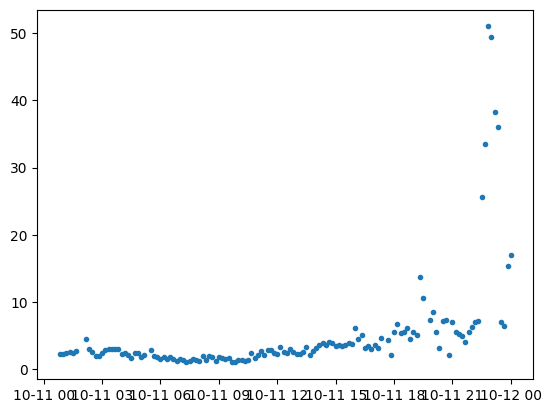

In [16]:
plt.plot(data_all_10min.HWS_100,'.')

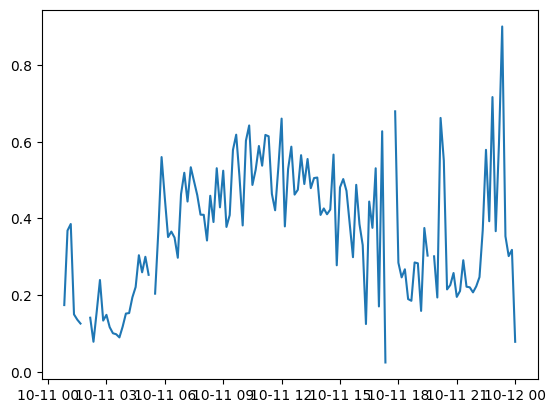

In [17]:
plt.plot(TI.HWS_100)

In [18]:
# definition altitudes
Z = np.linspace(50,500,46)

In [19]:
X, Y = np.meshgrid(HWS.index.strftime('%Y-%m-%d %H:%M'), Z)

In [20]:
# Fixing the issue by ensuring the dimensions of X, Y, and the transposed WD match. 
# It looks like the data frame WD might be empty or not have matching time intervals with X.

# Checking if WD is not empty and ensuring data is prepared for plotting.

if len(WD) > 0 and X.shape[0] == len(WD):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    plt.pcolormesh(X,Y,np.transpose(WD),cmap='twilight',shading='auto',vmin=0,vmax=360)
    ax1.set_ylim(0,500)
    plt.colorbar()
else:
    print("No data available for plotting or data dimension mismatch.")

No data available for plotting or data dimension mismatch.


In [21]:
# To resolve the error, we need to ensure that the data dimensions match. 
# It appears the data may be empty, so let's check HWS and ensure it has data before proceeding with the plotting.

# Checking if HWS is not empty and ensure data is available for plotting.
if not HWS.empty and X.shape[0] == len(HWS):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    plt.pcolormesh(X, Y, np.transpose(HWS), cmap='twilight', shading='auto', vmin=0, vmax=40)
    plt.colorbar()
else:
    print("No data available for plotting or dimensions mismatch.")

No data available for plotting or dimensions mismatch.


TypeError: unhashable type: 'numpy.ndarray'

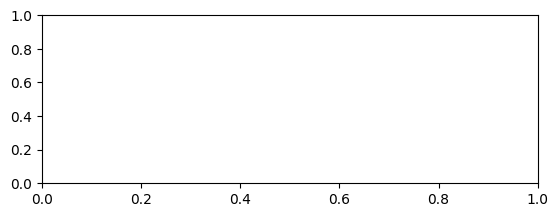

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.pcolormesh(X,Y,np.transpose(Status),cmap ='jet',shading='auto',vmin=0,vmax=1)
plt.colorbar()



<IPython.core.display.Javascript object>


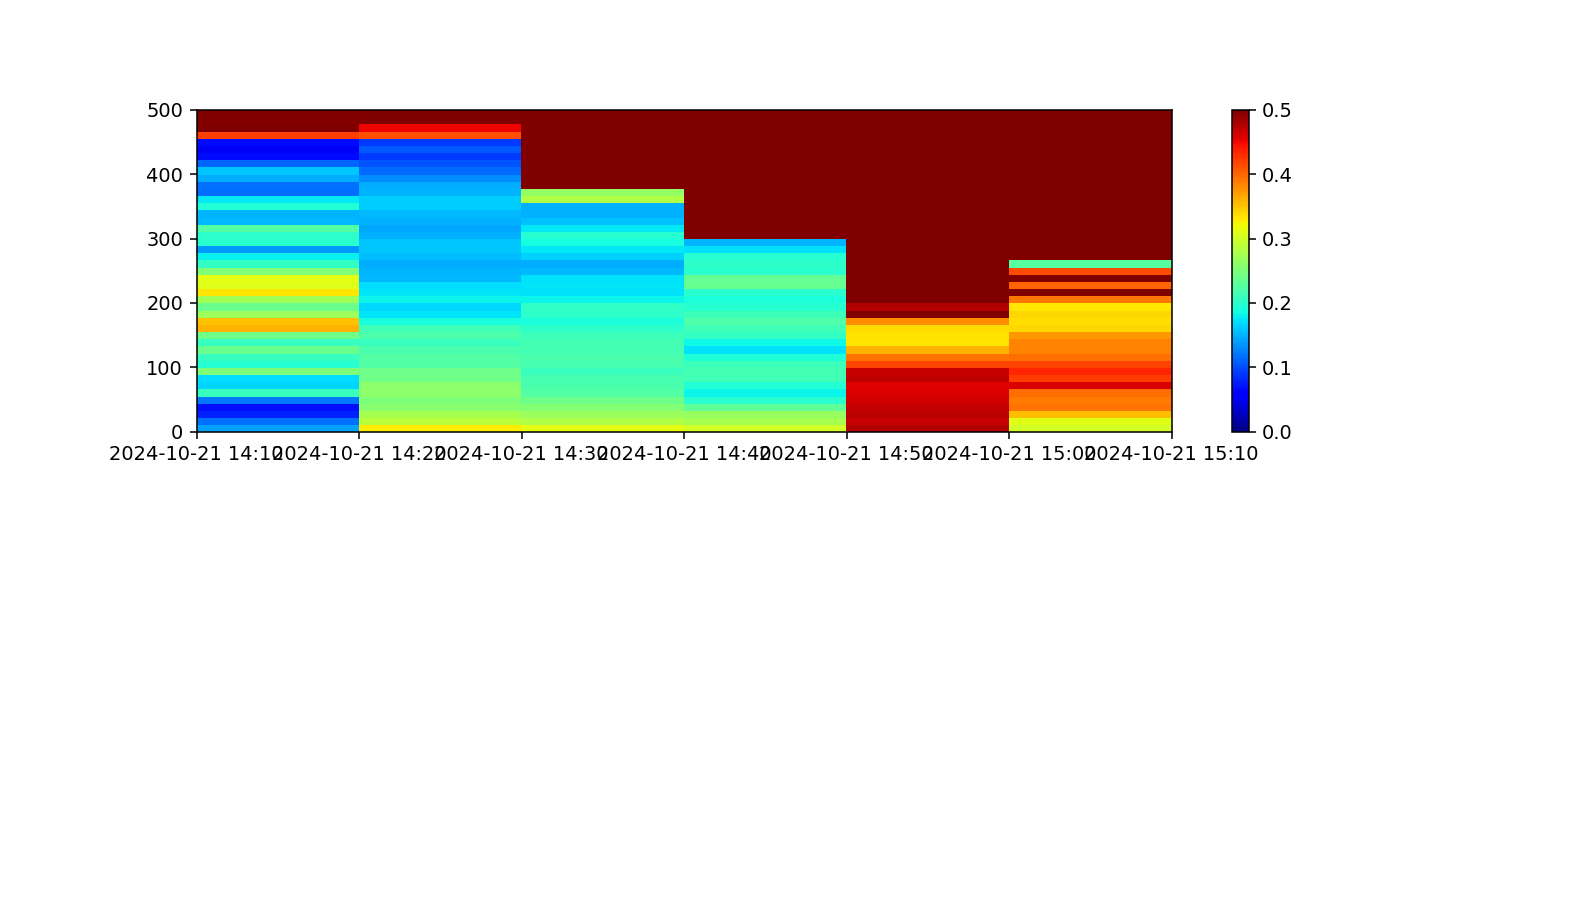

In [182]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.pcolormesh(X,Y,np.transpose(TI),cmap ='jet',shading='auto',vmin=0,vmax=0.5)
plt.colorbar()



In [200]:
HWS

,HWS_50,HWS_60,HWS_70,HWS_80,HWS_90,HWS_100,HWS_110,HWS_120,HWS_130,HWS_140,...,HWS_410,HWS_420,HWS_430,HWS_440,HWS_450,HWS_460,HWS_470,HWS_480,HWS_490,HWS_500
2024-10-21 14:10:00+00:00,5.922222,5.972222,6.006667,6.341111,6.367778,6.088889,6.175556,6.810000,7.098889,6.771111,...,14.622222,14.285556,14.333333,15.023333,13.950000,20.562222,21.285556,19.524444,20.063333,24.612222
2024-10-21 14:20:00+00:00,5.382372,5.912372,6.290641,6.427821,6.730705,6.969231,7.196731,7.555833,7.869359,8.158846,...,12.239359,12.350705,12.714551,12.954167,12.967564,14.284872,13.905385,16.239295,16.350064,16.713590
2024-10-21 14:30:00+00:00,5.441026,5.767885,5.962436,6.222821,6.493333,6.663718,6.846218,7.111154,7.399872,7.484487,...,14.048718,14.243718,14.901859,13.910064,15.986538,16.056282,17.772051,20.364423,22.126154,24.398077
2024-10-21 14:40:00+00:00,4.531346,4.962372,5.152051,5.388718,5.699038,5.914551,6.085385,6.306218,6.606538,6.768141,...,33.531923,38.440705,37.574744,42.022372,40.650513,40.663846,45.465000,46.107051,48.040962,50.286795
2024-10-21 14:50:00+00:00,6.881603,7.358718,7.693013,7.906795,8.309167,8.863782,8.985000,8.995449,9.607885,10.004872,...,41.788590,45.153013,47.552692,49.971026,40.248269,50.515577,41.032436,43.085064,45.722564,43.080513
2024-10-21 15:00:00+00:00,6.390064,6.543885,6.911911,7.348726,7.803057,8.308280,8.774204,9.508854,9.222357,9.819172,...,37.862930,39.729236,37.735350,41.318089,44.999554,49.130000,47.268535,44.258025,46.785541,52.629172
2024-10-21 15:10:00+00:00,7.508538,7.830846,8.198692,8.520846,8.978077,9.363308,9.678769,10.011462,10.565846,11.054846,...,34.992846,46.366692,48.885077,44.784538,46.691231,47.760231,52.748154,51.588154,48.604308,63.745154


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d5fa57e8-98cc-4985-8a7a-4040ee4f4c89' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>